# This notebook demonstrates how to monitor the training of a classifier on CIFAR-10 
##### We follows this tutorial: https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


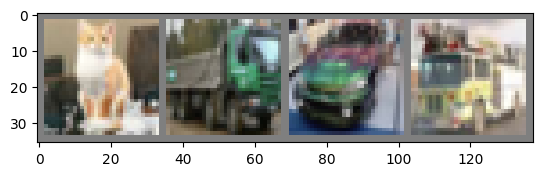

cat   truck car   truck


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
from pytorch_module_monitor import ModuleMonitor
import torch

# create the training monitor
training_monitor = ModuleMonitor(monitor_interval=100)

# add some metrics
training_monitor.add_activation_metric("l2norm", lambda activations: torch.linalg.vector_norm(activations, ord=2, dim=-1))
training_monitor.add_parameter_metric("l2norm", lambda parameters: torch.linalg.vector_norm(parameters.flatten(), ord=2))
training_monitor.add_gradient_metric("l2norm", lambda gradients: torch.linalg.vector_norm(gradients.flatten(), ord=2))

# provide the module that we want to monitor
training_monitor.set_module(net)

/home/sebastian/anaconda3/envs/tmcd/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import wandb

wandb.init(project="cifar-10", entity='sbordt-University of Tübingen')

In [ ]:
gradient_step = 1
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        ### Tell the monitor that we are starting a new gradient step ###
        training_monitor.begin_step(gradient_step)

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        ### Tell the monitor to monitor parameters and gradients now ###
        training_monitor.monitor_parameters()
        training_monitor.monitor_gradients()

        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

        gradient_step += 1

        ### Tell the monitor that we are done with the step. This will aggregate the metrics. ###
        training_monitor.end_step()

        # log everything to wandb
        metrics = {
            "loss": running_loss / 2000,
            "epoch": epoch,
            "step": gradient_step,
        }
        metrics.update(training_monitor.get_current_metrics())
        wandb.log(metrics)

print('Finished Training')

[1,  2000] loss: 2.149
[1,  4000] loss: 1.810
[1,  6000] loss: 1.688
[1,  8000] loss: 1.569
[1, 10000] loss: 1.523
[1, 12000] loss: 1.470
[2,  2000] loss: 1.420
[2,  4000] loss: 1.381
[2,  6000] loss: 1.356
[2,  8000] loss: 1.355
[2, 10000] loss: 1.332
[2, 12000] loss: 1.308
Finished Training


In [10]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor